In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **DATA INITIZLIZATION**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import gc

import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import math
import lightgbm as lgb
from tqdm.notebook import tqdm
tqdm.pandas()

#!pip install Wordbatch
#from wordbatch.models import FTRL, FM_FTRL  # https://github.com/anttttti/Wordbatch
import xgboost
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer 
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
import scipy
from scipy.sparse import hstack

from sklearn.metrics import mean_squared_log_error
import pickle
import regex as re
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/Colab Notebooks/'

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
if 'train.tsv' not in os.listdir(): 
    !kaggle competitions download -c mercari-price-suggestion-challenge
    get_ipython().system_raw("7z x \*.7z && rm *.7z")
    get_ipython().system_raw("7z x \*.zip && rm *.zip")

 78% 58.0M/74.3M [00:00<00:00, 125MB/s]
100% 74.3M/74.3M [00:00<00:00, 214MB/s]
  0% 0.00/7.77M [00:00<?, ?B/s]
100% 7.77M/7.77M [00:00<00:00, 71.6MB/s]
 79% 27.0M/34.0M [00:00<00:00, 50.4MB/s]
100% 34.0M/34.0M [00:00<00:00, 85.8MB/s]
  0% 0.00/170k [00:00<?, ?B/s]
100% 170k/170k [00:00<00:00, 174MB/s]
 93% 273M/294M [00:01<00:00, 218MB/s]
100% 294M/294M [00:01<00:00, 218MB/s]


In [ ]:
import pandas as pd

train_df = pd.read_csv('train.tsv', sep='\t')

# Price range should be $5-$2000, https://www.mercari.com/us/help_center/article/69
train_df = train_df[train_df['price']>=5]  # Removing the prodicts with prices less than 5
train_df = train_df[train_df['price']<=2000]  # Removing the prodicts with prices more than 2000
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


**Adding log price column**

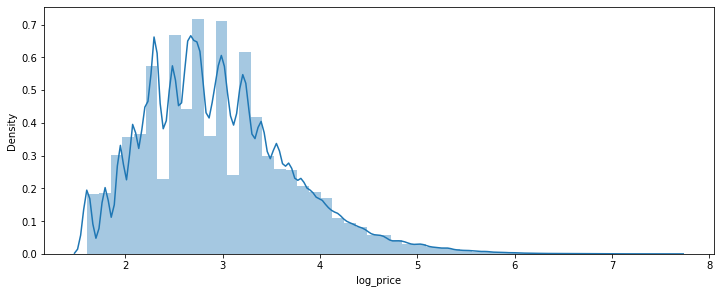

In [ ]:
from scipy import stats

train_df['log_price'] = np.log(train_df['price'].values)

plt.figure(figsize=(12,10))
plt.subplot(211)
sns.distplot(train_df['log_price'])

**Train Test Split**

In [ ]:
X = train_df.drop(['train_id','log_price','price'], axis=1)
y = train_df['log_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
del X, y, train_df

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1157452, 6)
(1157452,)
(289364, 6)
(289364,)


# **FEATURE ENGINEERING**

### **Filling missing values**

In [ ]:
def fill_missing_values(df):
    """
    Description:
    Filling null values in all columns.

    Input: Dataframe with null values
    Output: Dataframe with no null values
    """
    df['name'].fillna('unk_name', inplace=True)
    df['category_name'].fillna('unk_cat', inplace=True)
    df['brand_name'].fillna('unk_brand', inplace=True)
    df['item_description'].fillna('unk_descr', inplace=True)
    return df

### **Text Pre-processing**

In [ ]:
import re
import string

def decontract_text(phrase):
    """
    This utility funciton will be used as a part of preprocessing the text.
    It will expand the contracted words. For eg: won't -> will not, I'm -> I am.
    """
    phrase = str(phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def stem_sentence(sentence):
    ps = PorterStemmer()
    words = word_tokenize(sentence)
    root = []
    for w in words: 
        root.append(ps.stem(w))
    return " ".join(root)

def preprocess_descriptive_text_column(sentance):
    """
    Description:
    This function will process the text data.
    This function will perform decontracting words, removing stop words, removing special characters and then apply stemming on the words in the sentence.

    Input: original sentence
    Output: processed sentence
    """
    # https://gist.github.com/sebleier/554280
    # we are removing the negative words from the stop words list: 'no', 'nor', 'not', 'shouldn't, won't, etc.
    stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
                "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
                'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
                'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
                'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
                'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
                'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
                'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
                'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
                'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
                's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
                've', 'y']

    sent = decontract_text(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\\"', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)

    root_sent = stem_sentence(sent.lower().strip())
    return root_sent

### **Fill Missing Brand Names**

In [ ]:
import pickle
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brands_list.pkl', 'rb') as f:
    existing_brands = pickle.load(f)
    
with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/brand_names_categories_dict.pkl', 'rb') as f:
    brand_names_categories = pickle.load(f)

In [ ]:
def brand_guesser(row):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want our guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe row with missing brand names
    Output: dataframe row with filled brand names
    """
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    brand, name, cn = row
    brand = brand.lower()
    if brand=='unk_brand':
        for brand in existing_brands:
            if brand in name.lower() and cn in brand_names_categories[brand]:
                return brand
            
    return brand

### **Split Categories**

In [ ]:
def split_text(text):
    if text=='unk_cat':
        return ["No Label", "No Label", "No Label"]
    return text.split("/")

def split_categories(df):
    """
    Desription:
    This function separates the categories into its three parts. 
    Main category, Sub-category 1 and Sub-category 2
    Then it will remove the original category_name field.

    Input: Dataframe having category_name field
    Output: Dataframe with splitted categories
    """
    df['general_cat'], df['subcat_1'], df['subcat_2'] = zip(*df['category_name'].apply(lambda x: split_text(x)))
    df = df.drop('category_name', axis=1)
    return df

### **Adding Item Description len and Item Name len**

In [ ]:
from sklearn.preprocessing import StandardScaler
def get_len_feature(col_series, scaler_text_len=None):
    """
    Description:
    This funciton will calculate the word count of the text and standardize it.

    Input: Series, fitted scaler[optional; used during inference]
    Output: standardized text length for each product and object of the fitted scaler
    """
    text_len = col_series.apply(lambda x: len(x.split()))
    if scaler_text_len==None:
        scaler_text_len = StandardScaler()
        scaler_text_len.fit(text_len.values.reshape(-1, 1))
    text_len = scaler_text_len.transform(text_len.values.reshape(-1, 1))
    return text_len, scaler_text_len

### **Add is_expensive**

In [ ]:
def get_is_expensive_feature(df):
    """
    Description:
    This funciton will generate a feature which will tell if the brand is expensive or not.

    Input: Dataframe
    Output: Sparse is_expensive data
    """
    with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/expensive_brands.pkl', 'rb') as f:
        expensive_brands = pickle.load(f)
    
    is_expensive_binary = df['brand_name'].apply(lambda x: 1 if x in expensive_brands else 0)
    is_expensive_binary = scipy.sparse.csr_matrix(is_expensive_binary.values)
    is_expensive_binary = is_expensive_binary.reshape(-1,1) # Now the shape will be (1111901, 1)
    return is_expensive_binary

### **Make Shipping data sparse**

In [ ]:
def get_shipping_feature(df):
    sparse_shipping = scipy.sparse.csr_matrix(df['shipping'].values)
    sparse_shipping = sparse_shipping.reshape(-1,1) # Now the shape will be (1111901, 1)
    return sparse_shipping

### **Vectorizing data**

In [ ]:
def vectorize_data(col_data, vectorizer=None):
    """
    Description:
    This funciton will vectorize the input column data.

    Input: dataframe column
    Output: one-hot encoded values and the fitted vectorizer
    """
    if vectorizer==None:
        vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=100000)
        vectorizer.fit(col_data)
    ohe_data = vectorizer.transform(col_data)
    return ohe_data, vectorizer

### **Feature Engineering pipeline**

In [ ]:
def feature_pipeline(X_data, general_cat_vectorizer=None, subcat_1_vectorizer=None, subcat_2_vectorizer=None, brand_name_vectorizer=None, item_name_vectorizer=None, 
                     item_desc_vectorizer=None, scaler_name_len=None, scaler_desc_len=None):
    """
    Description: This function will do all the feature engineering on the input X_data,
                and create a final data, ready for training.

    Input: Original input dataframe, 
                    the fitted vectorizers for all categorical and text columns [optional: used during inference],
                    scalers [optional: used during inference]
    Output: Featurized data
    """
    print()
    print("Filling missing values...")
    X_data = fill_missing_values(X_data)

    #X_data['item_description'] = preprocess_descriptive_text_column(X_data['item_description'].values)
    #X_data['name'] = preprocess_descriptive_text_column(X_data['name'].values)
    #X_data['item_description'] = X_data['item_description'].apply(lambda x: str(x).lower()) ### temp step ###
    #X_data['name'] = X_data['name'].apply(lambda x: str(x).lower())                         ### temp step ###
    print("pre-processing text data...")
    X_data['item_description'] = X_data['item_description'].progress_apply(preprocess_descriptive_text_column) ### temp step ###
    X_data['name'] = X_data['name'].progress_apply(preprocess_descriptive_text_column)                         ### temp step ###
    X_data['brand_name'] = X_data['brand_name'].progress_apply(lambda x: str(x).lower())

    print("Guessing the missing brands...")
    X_data['brand_name'] = X_data[['brand_name','name', 'category_name']].progress_apply(brand_guesser, axis = 1)

    print("Splitting categories...")
    X_data = split_categories(X_data)

    print('Getting word lengths')
    name_len, scaler_name_len =  get_len_feature(X_data['name'], scaler_name_len)
    desc_len, scaler_desc_len =  get_len_feature(X_data['item_description'], scaler_desc_len)

    print("Getting is_expensive brand feature...")
    sparse_is_expensive = get_is_expensive_feature(X_data)

    print("Getting sparse shipping data...")
    sparse_shipping = get_shipping_feature(X_data)

    print("OHE vectorizing the text and categorical variables...")
    general_cat_ohe, general_cat_vectorizer = vectorize_data(X_data['general_cat'].values.astype('U'), general_cat_vectorizer)
    print("general cat done...")
    subcat_1_ohe, subcat_1_vectorizer = vectorize_data(X_data['subcat_1'].values.astype('U'), subcat_1_vectorizer)
    print("sub cat 1 done...")
    subcat_2_ohe, subcat_2_vectorizer = vectorize_data(X_data['subcat_2'].values.astype('U'), subcat_2_vectorizer)
    print("sub cat 2 done...")
    brand_name_ohe, brand_name_vectorizer = vectorize_data(X_data['brand_name'].values.astype('U'), brand_name_vectorizer)
    print("brand name done...")
    item_name_ohe, item_name_vectorizer = vectorize_data(X_data['name'], item_name_vectorizer)
    print("item name done...")
    item_desc_ohe, item_desc_vectorizer = vectorize_data(X_data['item_description'], item_desc_vectorizer)
    print("item description done...")

    print("Creating the final featurized dataset...")
    X_featurized = hstack((general_cat_ohe, subcat_1_ohe, subcat_2_ohe, brand_name_ohe, item_name_ohe, item_desc_ohe, 
                            desc_len, name_len, X_data['item_condition_id'].values.reshape(-1,1), sparse_shipping)).tocsr()

    print("Done!!!\n---------------------------\n")
    return X_featurized, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len


In [ ]:
X_tr, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len = feature_pipeline(X_train)
X_te, _, _, _, _, _, _, _, _ = feature_pipeline(X_test, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len)


Filling missing values...
pre-processing text data...



Guessing the missing brands...



Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Getting sparse shipping data...
OHE vectorizing the text and categorical variables...
general cat done...
sub cat 1 done...
sub cat 2 done...
brand name done...
item name done...
item description done...
Creating the final featurized dataset...
Done!!!
---------------------------


Filling missing values...
pre-processing text data...



Guessing the missing brands...



Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Getting sparse shipping data...
OHE vectorizing the text and categorical variables...
general cat done...
sub cat 1 done...
sub cat 2 done...
brand name done...
item name done...
item description done...
Creating the final featurized dataset...
Done!!!
---------------------------



In [26]:
# scalers = [general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len]
# with open('/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/zzFINAL COMPLETED/AAIC Submission/Pickled vars/vectorizers_scalers.pkl', 'wb') as f:
#     pickle.dump(scalers, f)

In [ ]:
# # https://stackoverflow.com/a/8980156/7697658
# scipy.sparse.save_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/X_tr_simple_MLP.npz", X_tr)
# scipy.sparse.save_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/X_te_simple_MLP.npz", X_te)

# **Simple MLP**

In [ ]:
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from numpy import array
from numpy import asarray
from numpy import zeros
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as ks
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM

In [ ]:
X_tr = scipy.sparse.load_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/X_tr_simple_MLP.npz")
X_te = scipy.sparse.load_npz("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/X_te_simple_MLP.npz")

In [ ]:
def create_simple_mlp_model(input_shape):   #input_shape=X_train.shape[1]
    model_in = Input(shape=(input_shape,), dtype='float32', sparse=True)
    out = Dense(192, activation='relu', kernel_regularizer=regularizers.l2(0.001))(model_in)
    out = Dropout(0.10)(out)
    out = Dense(128, activation='relu',  kernel_regularizer=regularizers.l1(0.0001))(out)
    #out = BatchNormalization()(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [ ]:
simple_model = create_simple_mlp_model(X_tr.shape[1])
simple_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 209104)]          0         
_________________________________________________________________
dense (Dense)                (None, 192)               40148160  
_________________________________________________________________
dropout (Dropout)            (None, 192)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 40,181,185
Trainable params: 40,181,185
Non-trainable params: 0
__________________________________________

In [ ]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [ ]:
# For more info on ModelCheckpoint, refer https://machinelearningmastery.com/check-point-deep-learning-models-keras/
from tensorflow.keras.callbacks import ModelCheckpoint
model_path = "/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Model_MLP_Checkpoints/BEST_MODEL.hdfs"
checkpoint_best = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='min')

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# https://stackoverflow.com/a/42963385/7697658
lrschedule_1 = ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.70, mode='min')

In [ ]:
simple_model.compile(loss='mse', optimizer=ks.optimizers.Adam(lr=0.0003), metrics=[tf.keras.metrics.RootMeanSquaredError()])
simple_model.fit(x=X_tr, y=y_train, batch_size=192, epochs=20, verbose=True, validation_data=(X_te, y_test),
                 callbacks=[checkpoint_best, lrschedule_1])

Epoch 1/20
6025/6029 [============================>.] - ETA: 0s - loss: 0.4221 - root_mean_squared_error: 0.5479
Epoch 00001: val_loss improved from inf to 0.30690, saving model to /content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/BEST_MODEL.hdfs
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/DL_data/BEST_MODEL.hdfs/assets
6029/6029 [==============================] - 61s 10ms/step - loss: 0.4220 - root_mean_squared_error: 0.5479 - val_loss: 0.3069 - val_root_mean_squared_error: 0.4828
Epoch 2/20
6025/6029 [============================>.] - ETA: 0s - loss: 0.3020 - root_mean_squared_error: 0.4864
Epoch 00002: va

In [ ]:
def evaluate_dl_model(model, X_data, y_act):
    y_pred = model.predict(X_data)

    act_prices = np.exp(y_act)
    pred_prices = np.exp(y_pred)

    rms = np.sqrt(mean_squared_log_error(act_prices, pred_prices))
    return rms

In [ ]:
rms_error=evaluate_dl_model(simple_model, X_te, y_test)
print(rms_error)

0.42138150149924974


### **Submission**

In [ ]:
test = pd.read_csv('test_stg2.tsv', sep='\t')

In [ ]:
X_te_submission, _, _, _, _, _, _, _, _ = feature_pipeline(test, general_cat_vectorizer, subcat_1_vectorizer, subcat_2_vectorizer, brand_name_vectorizer, item_name_vectorizer, item_desc_vectorizer, scaler_name_len, scaler_desc_len)


Filling missing values...
pre-processing text data...



Guessing the missing brands...



Splitting categories...
Getting word lengths
Getting is_expensive brand feature...
Getting sparse shipping data...
OHE vectorizing the text and categorical variables...
general cat done...
sub cat 1 done...
sub cat 2 done...
brand name done...
item name done...
item description done...
Creating the final featurized dataset...
Done!!!
---------------------------



In [ ]:
def create_submission_output_file(model, X_data, bs=64):
    submission_prices = model.predict(X_data, batch_size=bs)
    submission_prices = np.exp(submission_prices)
    submission_prices = np.squeeze(submission_prices, axis=1)
    my_submission = pd.DataFrame({'test_id': test['test_id'], 'price': submission_prices})
    my_submission.to_csv("/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Submission/submission_mlp.csv", index=False)

In [ ]:
model_path = "/content/drive/My Drive/Colab Notebooks/Applied AI Assignments/Case Study 1 Mercari Price Suggestion/Model_MLP_Checkpoints/BEST_MODEL.hdfs"
model_best = tf.keras.models.load_model(model_path)

In [ ]:
create_submission_output_file(model_best, X_te_submission)

# **Kaggle Submission Score**

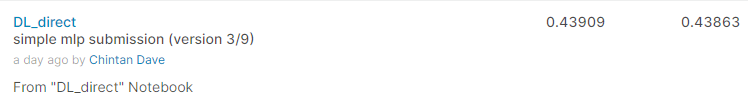